In [ ]:
# All the references to equations in this notebook
# can be found in arXiv

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math, cmath
from scipy.integrate import odeint

In [2]:
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer
from qiskit import execute, transpile
from qiskit.extensions import UnitaryGate, HamiltonianGate
from qiskit.providers.jobstatus import JobStatus

In [3]:
from qiskit import IBMQ

In [4]:
def progress_bar(i, n, m, show_per = True):
    """ Gererates the string of a progress bar.
    
    Output
    pb: string with a progress bar of the
        form [*****     ]
    
    Parameters
    i: integer variable going from 0 to n
    n: maximum integer value of i
    m: number of sites in the progress bar
    
    """
    
    pb = '['
    nst = math.ceil(i / n * m)
    for ii in range(nst):
        pb += '*'
    for ii in range(m-nst):
        pb += ' '
    pb += ']'
    if show_per:
        pb += ' [' + str(math.ceil(100 * i /(tdiv + 1))) + '%]' 
    
    return pb
        

In [5]:
def rho_dot(rho, t, args, C):
    """
    Computes the time derivative of the density matrix
    coefficients in terms of the structure constants C
    of the base. This function implements Eq. (61).
    
    Output
    rho_dot: numpy array containing the elements of
        the time derivative of the density matrix
        coefficients in terms of the structure constants
        Q of the base
    
    Time derivative of the density matrix coefficients in
    terms of the structure constants Q of the base
    
    Parameters
    rho: vector (list or numpy array) containing the elements
        of the density matrix.
    t: time variable
    args: list containing the Hamiltonian parameters.
    C: numpy array containing the structure constants
        of the base.
    
    """
    a = ham_coefs(t, args)
    mat = np.transpose(np.tensordot(a, C, axes = ([0],[0])))
    rho_dot = np.matmul(mat, rho)
    
    return rho_dot

In [6]:
def classical_sol(tmin, tmax, tdiv, rho0, args, C):
    """Obtains the classical solution for the coefficients of the
    density matrix numerically solving the time dependent
    von Neumann equation following the procedure outlined
    in the Supplemental Material.
    
    Output
    np.array(t_list): numpy array with the list of times used in the
        classical simulation.
    np.array(probs_list): numpy array with the list of probabilieties
        of the classical simulation corresponding to t_list.
    np.array(rho_list): numpy array with the list of density matrix
        coefficients corresponding to t_list.
    
    Parameters
    tmin: initial time in the classical simulation.
    tmax: final time in the classical simulation.
    tdiv: time divisions in the classical simulation.
    rho0: initial coefficients of the density matrix.
    args: list of the Hamiltonian arguments.
    C: numpy array containing the structure constants
        of the base.
    """
    
    #odeint

    dt = (tmax - tmin)/tdiv

    probs_list = []
    rho_list = []
    t_list = []

    for k in range(tdiv):
        t = k * dt
        t_list.append(t)

    rhos = odeint(rho_dot, rho0, t_list, args=(args,C))

    for rho in rhos:
        probs = [amp ** 2 for amp in rho]
        probs_list.append(probs)
        rho_list.append(rho)

    return np.array(t_list), np.array(probs_list), np.array(rho_list)

In [7]:
def list_states(nq):
    """Lists the possible states in binary format of a
    register with nq qubits.
    
    Output
    states: list of strings in binary format containing the list
        of all possible states.
    
    Parameters
    nq: integer of the number of qubits.
    
    """
    states = []
    for k in range(2 ** nq):
        kbin = bin(k)[2:]
        while len(kbin) < nq:
            kbin = '0' + kbin
        states.append(kbin)
        
    return states

In [8]:
def Ui_gate(rho0, nq):
    """Calculates the U_i gate that initializes the second
    register to the density matrix elements.
    This function implements the initialization of
    the quantum circuit given by Eq. (67).
    
    Ouptut
    qc.to_gate(): Qiskit gate of the initialization unitary
        Householder matrix.
    
    Parameters
    rho0: initial coefficients of the density matrix.
    nq: integer number of the number of qubits.
    
    """
    
    dim = 2**(nq - 1)
    
    u = np.zeros(dim)
    u[0] = 1.0
    
    r0 = rho0 / np.sqrt(np.dot(rho0, rho0))
    
    w = np.array([r0 - u])
    
    #Householder matrix
    H = np.identity(dim) - np.matmul(np.transpose(w), w) / (1.0 - r0[0])
    
    qcH = QuantumCircuit(nq - 1)
    qcH.append(UnitaryGate(H), range(nq - 2, -1, -1))
    UH = qcH.to_gate(label='$U_H$').control(1)
      
    qc = QuantumCircuit(nq)
    
    qc.h(nq - 1)
    qc.append(UH, range(nq - 1, -1, -1))
    qc.x(nq - 1)
    
    for jj in range(nq - 1):
        qc.ch(nq - 1, jj)
    
    qc.x(nq - 1)
    
    return qc.to_gate(label='$U_I$')

In [9]:
def M_gate(alpha, nq, pauli_l):
    """Composes the M gate through a HamiltonianGate.
    This function implements the gate M in Fig. 3
    or Eq. (71)
    
    Output
    qM.to_gate(): gate of the M transformation
    
    Parameters
    alpha: numpy array containing the parameters of
        the M unitary transformation.
    nq: integer number of the number of qubits.
    pauli_l: list of lists of tuples containing the Pauli
       operator corresponding to the projection of C_k^{n}
       on h_i^{2n} given by Tr[C_k^{n}h_i^{2n}]h_i^{2n}
       and the corresponding coefficients Tr[C_k^{n}h_i^{2n}].
    """
    
    qM = QuantumCircuit(nq - 1)
    
    en_pauli_l = list(enumerate(pauli_l))
    en_pauli_l.reverse()
    
    for k, pau_l in en_pauli_l:
        for pau in pau_l:
            Hg = HamiltonianGate(pau[0], alpha[k] * pau[1])
            qM.append(Hg, range(nq - 2, -1 , -1))
    
    return qM.to_gate(label='M')

In [10]:
def qcircuit(dt, n, rho0, args, nq, pauli_l):
    """Builds the quantum circuit for n time steps of the
    M gate. This function implements the quantum circuit
    shown in Fig. 1.
    
    Output
    qcc: Qiskit QuantumCircuit containing a circuit of n
        time steps
        
    Parameters
    dt: real number of the size of the time step.
    n: integer number of time steps.
    args: list of the Hamiltonian arguments.
    rho0: initial coefficients of the density matrix.
    nq: integer number of the number of qubits.
    pauli_l: list of lists of tuples containing the Pauli
       operator corresponding to the projection of C_k^{n}
       on h_i^{2n} given by Tr[C_k^{n}h_i^{2n}]h_i^{2n}
       and the corresponding coefficients Tr[C_k^{n}h_i^{2n}]

    """
    
    qc = QuantumCircuit(nq - 1, name='$M({\\bf \\alpha})$')
    qcc = QuantumCircuit(nq, nq)
    Ui = Ui_gate(rho0, nq)
    qcc.append(Ui, range(nq))
    
    for k in range(n):
        dt_a = dt * ham_coefs(k * dt, args)

        qM = M_gate(dt_a, nq, pauli_l)

        qc.append(qM, range(nq - 1))
    
    #build controlled M gate 
    cM_gate = qc.to_gate().control(1)

    qcc.append(cM_gate,  range(nq - 1, -1, -1))
    
    qcc.h(nq - 1)

    qcc.barrier(range(nq))

    qcc.measure(range(nq), range(nq))
    
    return qcc

In [11]:
# quantum algorithm solution
def build_quantum_run(tmin, tmax,
                      tdiv,
                      ndat,
                      args,
                      rho0,
                      pauli_l,
                      nq,
                      backend,
                      verbose=True):
    
    """Quantum algorithm. Builds a list of ndat
    circuits that evolve the density matrix through
    a total of tdiv time divisions.
    
    Output
    qcs: list of Qiskit QuantumCircuits.
    trans_qcs: list of transpiled QuantumCircuits.
    t_list_qg: numpy array containing the ndat times
        of the quantum simulation.
        
    Parameters
    tmin: initial time in the classical simulation.
    tmax: final time in the classical simulation.
    tdiv: time divisions in the classical simulation.
    ndat: integer with the number of circuits.
    args: list of the Hamiltonian arguments.
    rho0: initial coefficients of the density matrix.
    pauli_l: list of lists of tuples containing the Pauli
       operator corresponding to the projection of C_k^{n}
       on h_i^{2n} given by Tr[C_k^{n}h_i^{2n}]h_i^{2n}
       and the corresponding coefficients Tr[C_k^{n}h_i^{2n}]
    nq: integer number of the number of qubits.
    backend: backend used to perform the circuit simulation.
    verbose: boolean, if verbose==True the stage of the
        calculation is printed, otherwise the stage of
        the calculations are not printed.
    """
    
    dim = np.shape(C)[0]
    
    t_list_qg = []

    qcs = []
    
    for j in range(tdiv + 1):
        
        if verbose:
            print('builing quantum circuits ',j+1,'/',tdiv+1,
                  progress_bar(j, tdiv+1, 10),
                  '           ', sep= '', end='\r')

        if j % (tdiv // ndat) == 0:

            t_list_qg.append(j * dt)

            qc = qcircuit(dt, j, rho0, args, nq, pauli_l)

            qcs.append(qc)
            
            
    if verbose:
        print('')
        print('transpiling quantum circuits')
        
    tran_qcs = transpile(qcs, backend=backend)
    
    
    return qcs, tran_qcs, t_list_qg
    

In [12]:
def process_results(dim, nq, shots, rho0, results):
    """Once the quantum circuits resulting from build_quantum_run
    have been excecuted and job.status()==JobStatus.DONE
    process_results works out the density matrix coefficients
    and the corresponding probabilities. This function mainly
    uses Eqs. (78) and (79) to compute the density matrix
    coefficients.
    
    Output
    probs_list: list of probabilities corresponding to rho_list.
    rho_list: list of density matrix coefficients as a function
        of the corresponding times.
    
    Parameters
    dim: integer with the total number of states
    nq: integer with the number of qubits.
    shots: number of circuit executions.
    rho0: initial coefficients of the density matrix.
    results: Qiskit Result of the circuit execution.
    """
    
    n0 = np.sqrt(np.dot(rho0, rho0))
    
    counts = results.get_counts()
    
    probs_list = []

    states = list_states(nq)

    for count in counts:
        probs = [count.get(state,0)/shots for state in states]
        probs_list.append(probs)

    probs_list = np.array(probs_list)
    
    rho_list = []

    system_states = list_states(nq - 1)

    for count in counts:
        line = []
        for state in system_states:
            p0 = count.get('0' + state,0)/shots
            p1 = count.get('1' + state,0)/shots

            a = n0 * np.sqrt(2**(nq - 1)) * (p0 - p1)
            
            line.append(a)

        rho_list.append(line)

    rho_list = np.array(rho_list)
    
    return probs_list, rho_list

In [13]:
def pauli_base(nq):
    """Generates all the elements of an algebra given by
    (1/2)^{n/2}\sigma_{i_1} \otimes \sigma_{i_2} \otimes
    ... \sigma_{i_n} using Eq. (B1) iteratively where
    \sigma_0 is the 2 x 2 identity matrix and \sigma_1,
    \sigma_2 and \sigma_3 are the Pauli matrices
    
    Output
    base_1: numpy array containing all the elements of
        the matrix base.
    
    Parameters
    nq: integer with the number of qubits.
    
    """
    base_0 = np.array([
        (1.0/np.sqrt(2.0) + 0j) * np.identity(2),
        (1.0/np.sqrt(2.0) + 0j) * np.array([[0, 1], [1, 0]]),
        (1.0/np.sqrt(2.0) + 0j) * np.array([[0, -1j], [1j, 0]]),
        (1.0/np.sqrt(2.0) + 0j) * np.array([[1, 0], [0, -1]])
    ])
    
    base_1 = base_0[:]
    
    for k in range(nq - 1):
        base_2 = []
        for el1 in base_1:
            for el0 in base_0:
                base_2.append(np.kron(el1, el0))
        base_1 = np.array(base_2)
    
    return base_1

In [14]:
def structure_constants_base(base):
    """Calculates the structure constants of base.
    This function implements Eqs. (B10) and (B12).
    
    Output
    C: numpy array containing the structure constants
       of the commutator of base.
    B: numpy array containing the structure constants
       of the anticommutator of base.
        
    Parameters
    base: numpy array containing all the elements of
        the matrix base.
    
    """
    dim = np.shape(base)[0]
    C = 0j * np.zeros((dim, dim, dim))
    B = 0j * np.zeros((dim, dim, dim))
    for k0, el0 in enumerate(base):
        for k1, el1 in enumerate(base):
            commu = np.matmul(el0, el1) - np.matmul(el1, el0) 
            anticommu = np.matmul(el0, el1) + np.matmul(el1, el0) 
            for k2, el2 in enumerate(base):
                C[k0, k1, k2] = -1j * np.trace(np.matmul(commu, el2)) / np.trace(np.matmul(el2, el2))
                B[k0, k1, k2] = np.trace(np.matmul(anticommu, el2)) / np.trace(np.matmul(el2, el2))
                
    return [C, B]

In [15]:
def structure_constants_recursive(nq):
    """Recursively calculates the structure constants of base.
    This function implements Eqs. (B17) and (B18).
    
    Output
    Cn: numpy array containing the structure constants
        of the commutator of base.
    Bn: numpy array containing the structure constants
        of the anticommutator of base.s
        
    Parameters
    nq: ingeger with the number of qubits
    """
    base = pauli_base(1)
    
    C1, B1 = structure_constants_base(base)
    Cn = C1[:]
    Bn = B1[:]
    
    for _ in range(nq-1):
        Cnp = (np.kron(Bn, C1) + np.kron(Cn, B1))/2.0
        Bnp = (np.kron(Bn, B1) - np.kron(Cn, C1))/2.0
        Cn = Cnp[:]
        Bn = Bnp[:]
    
    return [Cn, Bn]

In [16]:
def ham_gate_coefs(nq):
    
    """Calculates the Hamiltonian gate coefficients
    Tr[C_k h_i^{(2)}] = Tr[C_k^{n}h_i^{2n}] recursively.
    This function implements the computation of such
    coefficients appearing in Eqs. (75), (B21) and (B22).
    
    Output
    Chn: numpy array of Tr[C_k^{nq}h_i^{2nq}]
    Bhn: numpy array of Tr[B_k^{nq}h_i^{2nq}]
     
    Parameters
    nq: integer with the number of qubits
    """
        
    h = pauli_base(2)
    C1, B1 = structure_constants_recursive(1)
    
    Ch1 = np.trace(np.tensordot(C1, h, axes = ([2,],[1,])), axis1 = 1, axis2 = 3)
    Bh1 = np.trace(np.tensordot(B1, h, axes = ([2,],[1,])), axis1 = 1, axis2 = 3)
    Chn = Ch1[:]
    Bhn = Bh1[:]
    
    for _ in range(nq-1):
        Chnp = (np.kron(Bhn, Ch1) + np.kron(Chn, Bh1))/2.0
        Bhnp = (np.kron(Bhn, Bh1) - np.kron(Chn, Ch1))/2.0
        Chn = Chnp[:]
        Bhn = Bhnp[:]
    
    return Chn, Bhn


In [17]:
def int_to_pauli(n, nq):
    """Converts an integer n in decimal base to
    the corresponding Pauli string in base four
    using the Qiskit standard notation I, X, Y and Z.
    Exampes: n = 0 -> 'I', n = 1 -> 'X',
             n = 21 -> 'XXX', n = 52 -> 'ZXI',
             n = 692 -> 'YYZXI'.
             
    Output
    stn: string with the Pauli string using the
         Qiskit standard notation I, X, Y and Z.
    
    Parameters
    n: integer in decimal base
    
    """
    res = n
    pau = ['I', 'X', 'Y', 'Z']
    stn = ''
    while res > 0:
        mo = res % 4
        stn = pau[mo] + stn
        res = res // 4
    
    while len(stn) < nq - 1:
        stn = 'I' + stn
        
    return(stn)

In [18]:
def pauli_list(nq):
    """Generates a list of Pauli operators and their corresponding
    coefficients (1/2)^{n/2}Tr[C_k^{n}h_i^{2n}] of Eq. (74) to be used
    by the Hamiltonian gates of Eq. (71) .
    
    Output
    pauli_list: list of lists of tuples containing the Pauli
                operator corresponding to the projection of C_k^{n}
                on h_i^{2n} given by Tr[C_k^{n}h_i^{2n}]h_i^{2n}
                and the corresponding coefficients Tr[C_k^{n}h_i^{2n}]
    Parameters
    nq: integer with the number of qubits
    """
    Chn, _ = ham_gate_coefs((nq - 1) // 2)
    pauli_list = []
    for chn in Chn:
        line = []
        for i, ch in enumerate(chn):
            if np.abs(ch) > 0:
                line.append((Pauli(int_to_pauli(i, nq)), np.imag(ch)/np.sqrt(2**(nq - 1))))
        pauli_list.append(line)
    
    return pauli_list

In [19]:
#############################################
# EXAMPLE 1                                 #
# One spin 1/2 particle                     #
# subject to an oscillating magnetic field. #
#############################################

In [20]:
def ham_coefs(t, args):
    """Calculates the coefficients for the nuclear
    resonance Hamiltonian of a spin 1/2 particle.
    
    Output
    a: numpy array containing the Hamiltonian coefficients
    
    Parameters
    t: time variable.
    args: Hamiltonian arguments.
        omega: Angular frequency of the electromagnetic
            drive.
        omega0: energy separation of the two level
            system.
        omega1: Rabi frequency
    
    """

    
    dim, omega0, omega1, omega, phi = args
    a = np.zeros(dim)
    a[1] = omega1 * np.cos(omega * t) / np.sqrt(2.0)
    a[2] = -omega1 * np.cos(omega * t + phi) / np.sqrt(2.0)
    a[3] = -omega0 / np.sqrt(2.0)
    
    return a

In [21]:
# Calculation of the structure constants
# of the Pauli base and the list of Pauli
# projections over C_k

dim = 4
nq = 3

pauli_l = pauli_list(nq)
base = pauli_base(1)
sC, _ = structure_constants_recursive(1)
C = np.real(sC)

In [22]:
# Values of the
# Hamiltonian parameters

omega0 = 1.0
omega1 = 22.0
omega = 0.90
phi = np.pi/2

tmin = 0.0
tmax = 2 * np.pi/omega1

args = (dim, omega0, omega1, omega, phi)

In [23]:
# Initial conditions of the 
# density matrix coefficients
# expressed in terms of base

rho0 = [1/np.sqrt(2), 0.0, 0.0, -1/np.sqrt(2)]

In [24]:
# Classical algorithm solution
tdiv = 500

t_list_od, probs_list_od, rho_list_od = classical_sol(tmin, tmax, tdiv, rho0, args, C)

In [25]:
# Setting the parameters
# for the quantum gates

tdiv = 50
ndat = 50

dt = (tmax - tmin) / tdiv

In [26]:
# To run the circuit in the IBMQ qasm simulator
# load the IBMQ account

# Retrieve your api token from your IBMQ account
#api_token = 'api token'

#IBMQ.save_account(api_token, overwrite=True)
#IBMQ.load_account()

In [27]:
# Get the provider for your IBMQ account 
#provider = IBMQ.get_provider('ibm-q')


In [28]:
# Build and transpile quantum circuits for the whole run
# using the qasm simulator

backend = Aer.get_backend('qasm_simulator') # This is the local qasm simulator
#backend = provider.get_backend('ibmq_qasm_simulator') # This is the IBMQ qasm simulator
                                                       # To use this one it is necessary
                                                       # to load the IBM account with the
                                                       # instructions above.

qcs, tran_qcs, t_list_qg = build_quantum_run(tmin, tmax,
                                             tdiv,
                                             ndat,
                                             args,
                                             rho0,
                                             pauli_l,
                                             nq,
                                             backend,
                                             verbose=True)

 

builing quantum circuits 51/51[**********] [99%]           
transpiling quantum circuits


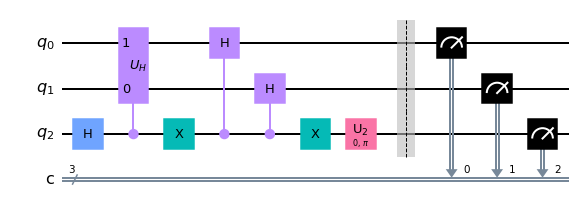

In [29]:
# Draw one of the
# quantum circuits

qcs[0].decompose().draw(output='mpl')

# or draw one of the transpiled
# quantum circuits
# This might be very large

#tran_qcs[0].decompose().draw(output='mpl')

In [30]:
# Execute the quantum circuits

shots = 2048 * 8
job = execute(tran_qcs, backend=backend, shots=shots)

In [31]:
# Check the job status

job_id = job.job_id()

print('job ID:     ', job_id)
print('job STATUS: ', job.status())

job ID:      92273c9d-30f6-4e4c-b075-7485c54cf495
job STATUS:  JobStatus.DONE


In [32]:
# Retrieve results from execution job
# if job.status() is JobStatus.DONE

results = job.result()

# Or retrieve another job with job_id
# from a remote run in IBMQ

#backend = provider.get_backend('ibmq_qasm_simulator')
#job_id = 'chtnpuai3durlgr0lp5g'
#job = backend.retrieve_job(job_id)
#results = job.result()

In [33]:
# Calculate the list of probabilities
# and the list of the density matrix
# coeficients

probs_list_qg, rho_list_qg = process_results(dim, nq, shots, rho0, results)

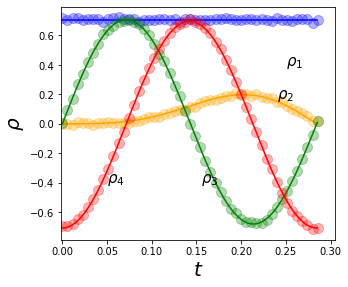

In [34]:
# Plot the density matrix coefficients
# from the classical and quantum
# simulations.
# The continuous lines are the classical
# simulation and the dots correspond
# to the quantum simulation.

# Plot quantum algorithm results if plot_qg=True
# otherwise do not plot them
plot_qg = True


colors = ['blue', 'orange', 'green', 'red']


fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111)

system_states = list_states(nq - 1)

for state in system_states:
    k = int(state, 2)
    if plot_qg :
        ax.plot(t_list_qg, rho_list_qg[:, k], 
               '.', alpha = 0.3, markersize = 20, color = colors[k])
    ax.plot(t_list_od, rho_list_od[:, k],
            '-' , color = colors[k])


ax.set_xlim([-0.001,0.305])
ax.set_xlabel('$t$', fontsize=20)
ax.set_ylabel('$\\rho $', fontsize=20)

plt.text(0.250,  0.400, '$\\rho_1$', fontsize=15)
plt.text(0.240,  0.170, '$\\rho_2$', fontsize=15)       
plt.text(0.155, -0.400, '$\\rho_3$', fontsize=15)
plt.text(0.050, -0.400, '$\\rho_4$', fontsize=15)

plt.subplots_adjust(left=0.16, right=0.92, bottom=0.14, top=0.95)
plt.savefig('figure2.pdf')

plt.show()

In [35]:
# Calculate the expected value of
# an operator using the density matrix
# coefficients as <O> = Tr[\hat{O}\hat{\rho}].
# Blue represents the population on the lowest
# energy level.
# Orange represents the population of the
# highest energy level.
# Green represents the expected value
# of the spin projection along z.

In [36]:
# Operators
# Population of the lowest energy level
pl = np.array([[0,0], [0,1]])
# Population of the highest energy level
ph = np.array([[1,0], [0,0]])

# Spin projection along z
Sz = np.array([[1/2 ,0], [0, -1/2]])


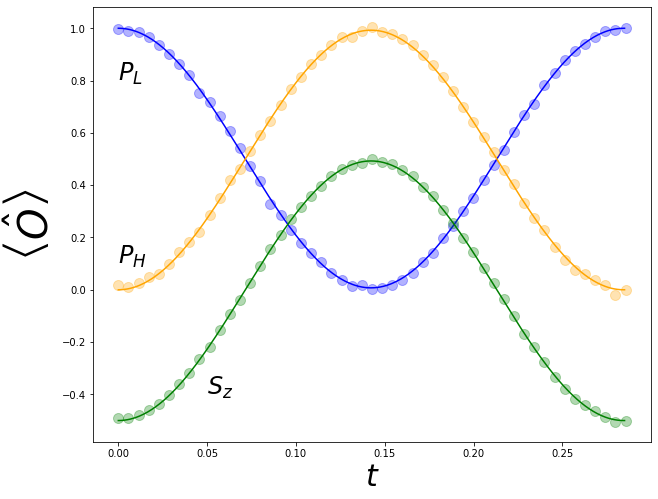

In [37]:
# Plot expected values for the first particle

ops = [pl, ph, Sz]

colors = ['blue', 'orange', 'green', 'red']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)


for jj, op in enumerate(ops):
    am_op_qg = 0.0j * np.zeros((np.shape(rho_list_qg)[0]))
    am_op_od = 0.0j * np.zeros((np.shape(rho_list_od)[0]))

    for kk in range(dim):
        proj = np.trace(np.matmul(base[kk], op))
        am_op_qg[:] += rho_list_qg[:, kk] * proj
        am_op_od[:] += rho_list_od[:, kk] * proj

    av_op_qg = np.real(am_op_qg[:])
    av_op_od = np.real(am_op_od[:])

    ax.plot(t_list_qg, av_op_qg, 
            '.', alpha = 0.3, markersize = 20, color = colors[jj])
    ax.plot(t_list_od, av_op_od,
            '-' , color = colors[jj])

ax.text(0.000,  0.800, '$P_{L}$', size=24)
ax.text(0.000,  0.100, '$P_{H}$', size=24)
ax.text(0.050, -0.400, '$S_{z}$', size=24)


ax.set_xlabel('$t$', fontsize=30)
ax.set_ylabel('$\\left\\langle \\hat{O}\\right\\rangle$', fontsize=40)

#plt.subplots_adjust(left=0.14, right=0.92, bottom=0.12, top=0.95)
#plt.savefig('figure-sm-02.pdf')

plt.show()

In [38]:
#############################################
# EXAMPLE 2                                 #
# Two spin 1/2 particles                    #
# subject to an oscillating magnetic field. #
#############################################

In [ ]:
def ham_coefs(t, args):
    """Calculates the coefficients for
    two spin 1/2 particles coupled through
    exchange interaction and subject to
    a time-varying magnetic field.
    
    Output
    ham: numpy array containing the Hamiltonian coefficients
    
    Parameters
    t: time variable.
    args: Hamiltonian arguments.
        omega: Angular frequency of the electromagnetic
            drive.
        omega0: energy separation of the two level
            system.
        omega1: Rabi frequency
        A: exchange interaction constant
    
    """

    
    dim, omega0, omega1, omega, A, phi = args
    ham = np.zeros(dim)
    ham[1]  = omega1 * np.cos(omega * t)
    ham[2]  = -omega1 * np.cos(omega * t + phi)
    ham[3]  = -omega0
    ham[5]  = A/2.0
    ham[4]  = ham[1]
    ham[8]  = ham[2]
    ham[12] = ham[3]
    ham[10] = ham[5]
    ham[15] = ham[5]
    
    return ham

In [ ]:
# Calculation of the structure constants
# of the Pauli base

dim = 16
nq = 5

pauli_l = pauli_list(nq)
base = pauli_base(2)
sC, _ = structure_constants_recursive(2)
C = np.real(sC)

In [ ]:
# Values of the
# Hamiltonian parameters

omega0 = 1.0
omega1 = 22.0
omega = 0.90
A = 3.0
phi = np.pi/2

tmin = 0.0
tmax = 2 * np.pi/omega1

args = (dim, omega0, omega1, omega, A, phi)

In [ ]:
# Initial conditions of the 
# density matrix coefficients
# expressed in terms of base.
# The first electron is completely
#

rho0 = [ 0.5, 0.0, 0.0,  0.5,
         0.0, 0.0, 0.0,  0.0,
         0.0, 0.0, 0.0,  0.0,
        -0.5, 0.0, 0.0, -0.5]

In [ ]:
# Classical algorithm solution
tdiv = 500

t_list_od, probs_list_od, rho_list_od = classical_sol(tmin, tmax, tdiv, rho0, args, C)

In [ ]:
# Setting the parameters
# for the quantum gates

tdiv = 50
ndat = 50

dt = (tmax - tmin) / tdiv

In [ ]:
# To run the circuit in the IBMQ qasm simulator
# load the IBMQ account

# Retrieve your api token from your IBMQ account
#api_token = 'api token'

#IBMQ.save_account(api_token, overwrite=True)
#IBMQ.load_account()

In [ ]:
# Get the provider for your IBMQ account 
#provider = IBMQ.get_provider('ibm-q')


In [ ]:
# Build and transpile quantum circuits for the whole run
# using the qasm simulator

backend = Aer.get_backend('qasm_simulator') # This is the local qasm simulator
#backend = provider.get_backend('ibmq_qasm_simulator') # This is the IBMQ qasm simulator
                                                       # To use this one it is necessary
                                                       # to load the IBM account.

qcs, tran_qcs, t_list_qg = build_quantum_run(tmin, tmax,
                                             tdiv,
                                             ndat,
                                             args,
                                             rho0,
                                             pauli_l,
                                             nq,
                                             backend,
                                             verbose=True)

In [ ]:
# Draw one of the
# quantum circuits

qcs[0].decompose().draw(output='mpl')

# or draw one of the transpiled
# quantum circuits
# This might be very large

#tran_qcs[0].decompose().draw(output='mpl')

In [ ]:
# Execute the quantum circuits

shots = 2048 * 16
job = execute(tran_qcs, backend=backend, shots=shots)

In [ ]:
# Check the job status

job_id = job.job_id()

print('job ID:     ', job_id)
print('job STATUS: ', job.status())

In [ ]:
# Retrieve results from execution job
# if job.status() is JobStatus.DONE

results = job.result()

# Or retrieve another job with job_id
# from a remote run in IBMQ

#backend = provider.get_backend('ibmq_qasm_simulator')
#job_id = 'chtnpuai3durlgr0lp5g'
#job = backend.retrieve_job(job_id)
#results = job.result()

In [ ]:
# Calculate the list of probabilities
# and the list of the density matrix
# coeficients

probs_list_qg, rho_list_qg = process_results(dim, nq, shots, rho0, results)

In [ ]:
# Plot the density matrix coefficients
# from the classical and quantum
# simulations.
# The continuous lines are the classical
# simulation and the dots correspond
# to the quantum simulation.

# Plot quantum algorithm results if plot_qg=True
# otherwise do not plot them
plot_qg = True

colors = ['blue', 'orange', 'green', 'red']

fig = plt.figure(figsize=(15,10))
plt.rc('axes', labelsize=20) 
gs = fig.add_gridspec(2,2, hspace=0.25,wspace=0.28)
ax = gs.subplots()

system_states = list_states(nq - 1)

tag_pos = [[0.105, 0.191], [0.248, -0.086], [0.125,  0.074], [0.171, -0.216],
           [0.144, 0.070], [0.195, -0.057], [0.119,  0.118], [0.103, -0.102],
           [0.106, 0.209], [0.255,  0.219], [0.010, -0.179], [0.176,  0.180],
           [0.174, 0.211], [0.197, -0.196], [0.028,  0.150], [0.163, -0.241]]
ins = ['(a)', '(b)', '(c)', '(d)']
ins_pos = [[-0.005, 0.150], [-0.005, 0.080], [-0.005, 0.150], [-0.005, 0.150]]

for state in system_states:
    k = int(state, 2)
    ii = k // 8
    jj = k % 8 // 4
    kk = k % 4

    xtag = tag_pos[k][0]
    ytag = tag_pos[k][1]
    xins = ins_pos[jj + 2 * ii][0]
    yins = ins_pos[jj + 2 * ii][1]
    
    tag = '$\\rho_{' + str(k + 1) + '}$'
    if plot_qg :
        ax[ii,jj].plot(t_list_qg, rho_list_qg[:, k], 
               '.', alpha = 0.3, markersize = 20, color = colors[kk])
    ax[ii,jj].plot(t_list_od, rho_list_od[:, k],
            '-' , color = colors[kk])
    ax[ii,jj].set_xlim([-0.01,0.30])
    ax[ii,jj].set_xlabel('$t$', fontsize=24)
    ax[ii,jj].set_ylabel('$\\rho $', fontsize=24)
    ax[ii,jj].text(xtag, ytag, tag, size=24)
    ax[ii,jj].text(xins, yins, ins[jj + 2 * ii], size=24)

#plt.savefig('figure3.pdf')
    
plt.show()

In [ ]:
# Calculate the expected value of
# an operator using the density matrix
# coefficients as <O> = Tr[\hat{O}\hat{\rho}].
# Blue represents the population on the lowest
# energy level.
# Orange represents the population of the
# highest energy level.
# Green represents the expected value
# of the spin projection along z.

In [ ]:
# Operators
# Population of the first particle's lowest energy level
p1l = np.kron([[0,0], [0,1]], np.identity(2))
# Population of the first particle's highest energy level
p1h = np.kron([[1,0], [0,0]], np.identity(2))
# Population of the second particle's lowest energy level
p2l = np.kron(np.identity(2), [[0,0], [0,1]])
# Population of the second particle's highest energy level
p2h = np.kron(np.identity(2), [[1,0], [0,0]])

# First particle's spin projection along z
S1z = np.kron([[1/2 ,0], [0, -1/2]], np.identity(2))
# Second particle's spin projection along z
S2z = np.kron(np.identity(2), [[1/2, 0], [0, -1/2]])


In [ ]:
# Plot expected values for the first particle

ops = [p1l, p1h, S1z]

colors = ['blue', 'orange', 'green', 'red']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)


for jj, op in enumerate(ops):
    am_op_qg = 0.0j * np.zeros((np.shape(rho_list_qg)[0]))
    am_op_od = 0.0j * np.zeros((np.shape(rho_list_od)[0]))

    for kk in range(dim):
        proj = np.trace(np.matmul(base[kk], op))
        am_op_qg[:] += rho_list_qg[:, kk] * proj
        am_op_od[:] += rho_list_od[:, kk] * proj

    av_op_qg = np.real(am_op_qg[:])
    av_op_od = np.real(am_op_od[:])

    ax.plot(t_list_qg, av_op_qg, 
            '.', alpha = 0.3, markersize = 20, color = colors[jj])
    ax.plot(t_list_od, av_op_od,
            '-' , color = colors[jj])

ax.text(0.000,  0.800, '$P_{1,L}$', size=24)
ax.text(0.120,  0.800, '$P_{1,H}$', size=24)
ax.text(0.050, -0.400, '$S_{1,z}$', size=24)
ax.text(0.260, -0.500, '(a)', size=42)


ax.set_xlabel('$t$', fontsize=30)
ax.set_ylabel('$\\left\\langle \\hat{O}\\right\\rangle$', fontsize=40)


#plt.subplots_adjust(left=0.14, right=0.92, bottom=0.12, top=0.95)
#plt.savefig('figure-sm-04a.pdf')

plt.show()

In [ ]:
# Plot expected values for the second particle

ops = [p2l, p2h, S2z]

colors = ['blue', 'orange', 'green', 'red']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)


for jj, op in enumerate(ops):
    am_op_qg = 0.0j * np.zeros((np.shape(rho_list_qg)[0]))
    am_op_od = 0.0j * np.zeros((np.shape(rho_list_od)[0]))

    for kk in range(dim):
        proj = np.trace(np.matmul(base[kk], op))
        am_op_qg[:] += rho_list_qg[:, kk] * proj
        am_op_od[:] += rho_list_od[:, kk] * proj

    av_op_qg = np.real(am_op_qg[:])
    av_op_od = np.real(am_op_od[:])

    ax.plot(t_list_qg, av_op_qg, 
            '.', alpha = 0.3, markersize = 20, color = colors[jj])
    ax.plot(t_list_od, av_op_od,
            '-' , color = colors[jj])

ax.text(0.000, -0.100, '$P_{2,L}$', size=24)
ax.text(0.000,  0.820, '$P_{2,H}$', size=24)
ax.text(0.120, -0.330, '$S_{2,z}$', size=24)
ax.text(0.260, -0.450, '(b)', size=42)

ax.set_xlabel('$t$', fontsize=30)
ax.set_ylabel('$\\left\\langle \\hat{O}\\right\\rangle$', fontsize=40)

#plt.subplots_adjust(left=0.14, right=0.92, bottom=0.12, top=0.95)
#plt.savefig('figure-sm-04b.pdf')

plt.show()